In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from glob import glob
import os
from tensorflow.keras.metrics import Recall, Precision, Accuracy, IoU
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
" Seeding """
np.random.seed(42)
tf.random.set_seed(42)


In [3]:
SIZE=256
def read_image_tf(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (SIZE, SIZE))
    x = x / 255.0
    return x.astype(np.float32)

def read_mask_tf(path):
    path = path.decode()
    y = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    y = cv2.resize(y, (SIZE, SIZE))
    y[y != 0] = 255
    y = y / 255.0
    y = (y > 0.5).astype(np.float32)
    y = np.expand_dims(y, axis=-1)
    return y

def tf_parse(x_path, y_path):
    def _parse(x_path, y_path):
        x = read_image_tf(x_path)
        y = read_mask_tf(y_path)
        return x, y

    x, y = tf.numpy_function(_parse, [x_path, y_path], [tf.float32, tf.float32])
    x.set_shape([SIZE, SIZE, 3])
    y.set_shape([SIZE, SIZE, 1])
    return x, y

def tf_dataset(x_paths, y_paths, batch_size=16, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((x_paths, y_paths))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


In [4]:
def iou(y_true, y_pred):
    y_true = tf.round(y_true)
    y_pred = tf.round(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + 1e-15) / (union + 1e-15)
    return iou


smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-7, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=False),
    TensorBoard()

]

In [6]:

import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers
weight_decay=1e-8
def conv_block(x, filters, dropout=False):
    x = layers.Conv2D(filters, (3, 3), padding="same", kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(filters, (3, 3), padding="same", kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    if dropout:
        x = layers.Dropout(0.5)(x)

    return x


def encoder_block(x, filters):
    c = conv_block(x, filters)
    p = layers.MaxPooling2D((2, 2))(c)
    return c, p

def decoder_block(x, skip, filters):
    x = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

def build_unet(input_shape):
    inputs = tf.keras.Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    # Apply dropout in encoder 4
    s4 = conv_block(p3, 512, dropout=True)
    p4 = layers.MaxPooling2D((2, 2))(s4)

    # Apply dropout in bottleneck
    b1 = conv_block(p4, 1024, dropout=True)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    return Model(inputs, outputs)

In [7]:
train_y = '/content/drive/MyDrive/PFA_Final/new_data/train/GT_TE'
train_x = '/content/drive/MyDrive/PFA_Final/new_data/train/images'
test_y = '/content/drive/MyDrive/PFA_Final/new_data/test/GT_TE'
test_x = '/content/drive/MyDrive/PFA_Final/new_data/test/images'
valid_y = '/content/drive/MyDrive/PFA_Final/new_data/valid/GT_TE'
valid_x = '/content/drive/MyDrive/PFA_Final/new_data/valid/images'

train_images = sorted(glob(os.path.join(train_x, "*.bmp")))
train_masks  = sorted(glob(os.path.join(train_y, "*.bmp")))

test_images = sorted(glob(os.path.join(test_x, "*.bmp")))
test_masks  = sorted(glob(os.path.join(test_y, "*.bmp")))

valid_images = sorted(glob(os.path.join(valid_x, "*.bmp")))
valid_masks  = sorted(glob(os.path.join(valid_y, "*.bmp")))

# Create datasets
train_dataset = tf_dataset(train_images, train_masks, batch_size=16)
test_dataset  = tf_dataset(test_images, test_masks, batch_size=16,shuffle=False)
valid_dataset = tf_dataset(valid_images, valid_masks, batch_size=16, shuffle=False)
print("Number of training samples:", len(train_images))
print("Number of validation samples:", len(valid_images))
print("Number of testing samples:", len(test_images))

metrics = [dice_coef, iou, 'accuracy', Recall(), Precision()]

Number of training samples: 995
Number of validation samples: 25
Number of testing samples: 25


In [ ]:

input_shape = ((SIZE, SIZE, 3))
modelte = build_unet(input_shape)
modelte.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4,weight_decay=1e-8),
              loss=dice_loss,
              metrics=metrics)

# Train with dataset
modelte.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=300,
    callbacks=callbacks,
)


Epoch 1/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 553s 7s/step - accuracy: 0.7694 - dice_coef: 0.3800 - iou: 0.3168 - loss: 0.6201 - precision: 0.3215 - recall: 0.8190 - val_accuracy: 0.8871 - val_dice_coef: 0.2112 - val_iou: 0.0972 - val_loss: 0.7832 - val_precision: 0.6659 - val_recall: 0.1237 - learning_rate: 1.0000e-04
Epoch 2/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 77s 851ms/step - accuracy: 0.9270 - dice_coef: 0.6391 - iou: 0.5958 - loss: 0.3609 - precision: 0.6371 - recall: 0.9001 - val_accuracy: 0.8830 - val_dice_coef: 0.5159 - val_iou: 0.4562 - val_loss: 0.4817 - val_precision: 0.5088 - val_recall: 0.8113 - learning_rate: 1.0000e-04
Epoch 3/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 81s 844ms/step - accuracy: 0.9454 - dice_coef: 0.7006 - iou: 0.6597 - loss: 0.2993 - precision: 0.7175 - recall: 0.8904 - val_accuracy: 0.9008 - val_dice_coef: 0.3115 - val_iou: 0.1955 - val_loss: 0.6655 - val_precision: 0.7914 - val_recall: 0.2390 - learning_rate: 1.0000e-04
Epoch 4/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 845ms/step 

In [ ]:
modelte.evaluate(test_dataset)# i didn't do the test here , no gpu to use in this session after completing the training phase:()

2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 6s/step - accuracy: 0.9665 - dice_coef: 0.9034 - iou: 0.8263 - loss: 0.0980 - precision: 0.8630 - recall: 0.9472


[0.09626275300979614,
 0.9057223796844482,
 0.8304380774497986,
 0.9677606225013733,
 0.9492618441581726,
 0.8641226887702942]

In [ ]:
def channel_attention(x, ratio=2, name_prefix="attention"):
    channel = x.shape[-1]
    shared_dense_one = layers.Dense(channel // ratio, activation='relu', kernel_initializer='he_normal', name=f"{name_prefix}_dense1")
    shared_dense_two = layers.Dense(channel, kernel_initializer='he_normal', name=f"{name_prefix}_dense2")

    avg_pool = layers.GlobalAveragePooling2D()(x)
    avg_pool = layers.Reshape((1, 1, channel))(avg_pool)
    avg_out = shared_dense_two(shared_dense_one(avg_pool))

    max_pool = layers.GlobalMaxPooling2D()(x)
    max_pool = layers.Reshape((1, 1, channel))(max_pool)
    max_out = shared_dense_two(shared_dense_one(max_pool))

    out = layers.Add(name=f"{name_prefix}_add")([avg_out, max_out])
    attention = layers.Activation('sigmoid', name=f"{name_prefix}_sigmoid")(out)

    scaled = layers.Multiply(name=f"{name_prefix}_multiply")([x, attention])
    out = layers.Add(name=f"{name_prefix}_final_add")([scaled, x])

    return out, attention, scaled


In [ ]:
def decoder_blockch(x, skip, filters, name_prefix="decoder"):
    x = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same", name=f"{name_prefix}_conv_transpose")(x)
    x = layers.Concatenate(name=f"{name_prefix}_concat")([x, skip])
    x = conv_block(x, filters)
    out, attention, scaled = channel_attention(x, name_prefix=f"{name_prefix}_channelattention")
    return out, attention, scaled


In [ ]:
def build_unetch_with_attention_features(input_shape):
    inputs = tf.keras.Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4 = conv_block(p3, 512, dropout=True)
    p4 = layers.MaxPooling2D((2, 2))(s4)

    b1 = conv_block(p4, 1024, dropout=True)

    d1, att1, feat1 = decoder_blockch(b1, s4, 512, name_prefix="decoder1")
    d2, att2, feat2 = decoder_blockch(d1, s3, 256, name_prefix="decoder2")
    d3, att3, feat3 = decoder_blockch(d2, s2, 128, name_prefix="decoder3")
    d4, att4, feat4 = decoder_blockch(d3, s1, 64, name_prefix="decoder4")


    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid", name="segmentation_output")(d4)

    return Model(inputs=inputs, outputs= outputs)

In [ ]:
input_shape = ((SIZE, SIZE, 3))
modelte_ch = build_unetch_with_attention_features(input_shape)
modelte_ch.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, weight_decay=1e-8),
    loss=dice_loss,
    metrics=metrics
)

In [ ]:
for layer in modelte_ch.layers:
    print(layer.name)


input_layer
conv2d
batch_normalization
activation
conv2d_1
batch_normalization_1
activation_1
max_pooling2d
conv2d_2
batch_normalization_2
activation_2
conv2d_3
batch_normalization_3
activation_3
max_pooling2d_1
conv2d_4
batch_normalization_4
activation_4
conv2d_5
batch_normalization_5
activation_5
max_pooling2d_2
conv2d_6
batch_normalization_6
activation_6
conv2d_7
batch_normalization_7
activation_7
dropout
max_pooling2d_3
conv2d_8
batch_normalization_8
activation_8
conv2d_9
batch_normalization_9
activation_9
dropout_1
decoder1_conv_transpose
decoder1_concat
conv2d_10
batch_normalization_10
activation_10
conv2d_11
batch_normalization_11
activation_11
global_average_pooling2d
global_max_pooling2d
reshape
reshape_1
decoder1_channelattention_dense1
decoder1_channelattention_dense2
decoder1_channelattention_add
decoder1_channelattention_sigmoid
decoder1_channelattention_multiply
decoder1_channelattention_final_add
decoder2_conv_transpose
decoder2_concat
conv2d_12
batch_normalization_12
ac

In [ ]:
layer_names = [
    "decoder1_channelattention_final_add",
    "decoder2_channelattention_final_add",
    "decoder3_channelattention_final_add",
    "decoder4_channelattention_final_add"
]
# Create a new model that outputs the attention layers
feature_extractor = tf.keras.Model(inputs=modelte_ch.input,
                                   outputs=[modelte_ch.get_layer(name).output for name in layer_names])



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

class FinalFeatureMapCallback(tf.keras.callbacks.Callback):
    def __init__(self, feature_extractor, val_data):
        super(FinalFeatureMapCallback, self).__init__()
        self.feature_extractor = feature_extractor
        self.val_data = val_data

    def on_train_end(self, logs=None):
        # Get the last image from the last batch of val_data
        last_image = None
        for batch in self.val_data:
            last_image = batch[0]  # (inputs, labels)

        if last_image is None:
            print("Validation data is empty.")
            return

        image = last_image[-1:]  # shape (1, H, W, C)

        # Get feature maps
        feature_maps = self.feature_extractor.predict(image)

        # Plot the first channel of each decoder output
        fig, axes = plt.subplots(1, len(feature_maps), figsize=(20, 5))
        for i, fmap in enumerate(feature_maps):
            fmap = np.squeeze(fmap)  # (H, W, C)
            axes[i].imshow(fmap[:, :, 0], cmap='jet')  # first channel
            axes[i].set_title(f'Decoder {i + 1}')
            axes[i].axis('off')

        plt.suptitle('Final Feature Maps (last val image, last epoch)')
        plt.show()


In [ ]:
feature_map_callback = FinalFeatureMapCallback(feature_extractor, val_data=valid_dataset)


Epoch 1/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 686s 9s/step - accuracy: 0.7860 - dice_coef: 0.4191 - iou: 0.3208 - loss: 0.5810 - precision: 0.3335 - recall: 0.7623 - val_accuracy: 0.8798 - val_dice_coef: 0.1743 - val_iou: 0.0014 - val_loss: 0.8238 - val_precision: 0.7263 - val_recall: 0.0017 - learning_rate: 1.0000e-04
Epoch 2/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 70s 903ms/step - accuracy: 0.9364 - dice_coef: 0.7360 - iou: 0.6146 - loss: 0.2640 - precision: 0.6897 - recall: 0.8481 - val_accuracy: 0.8808 - val_dice_coef: 0.0999 - val_iou: 0.0088 - val_loss: 0.8960 - val_precision: 0.8466 - val_recall: 0.0116 - learning_rate: 1.0000e-04
Epoch 3/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 898ms/step - accuracy: 0.9502 - dice_coef: 0.7863 - iou: 0.6709 - loss: 0.2137 - precision: 0.7579 - recall: 0.8530 - val_accuracy: 0.8855 - val_dice_coef: 0.1199 - val_iou: 0.0433 - val_loss: 0.8622 - val_precision: 0.8901 - val_recall: 0.0560 - learning_rate: 1.0000e-04
Epoch 4/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 899ms/step 

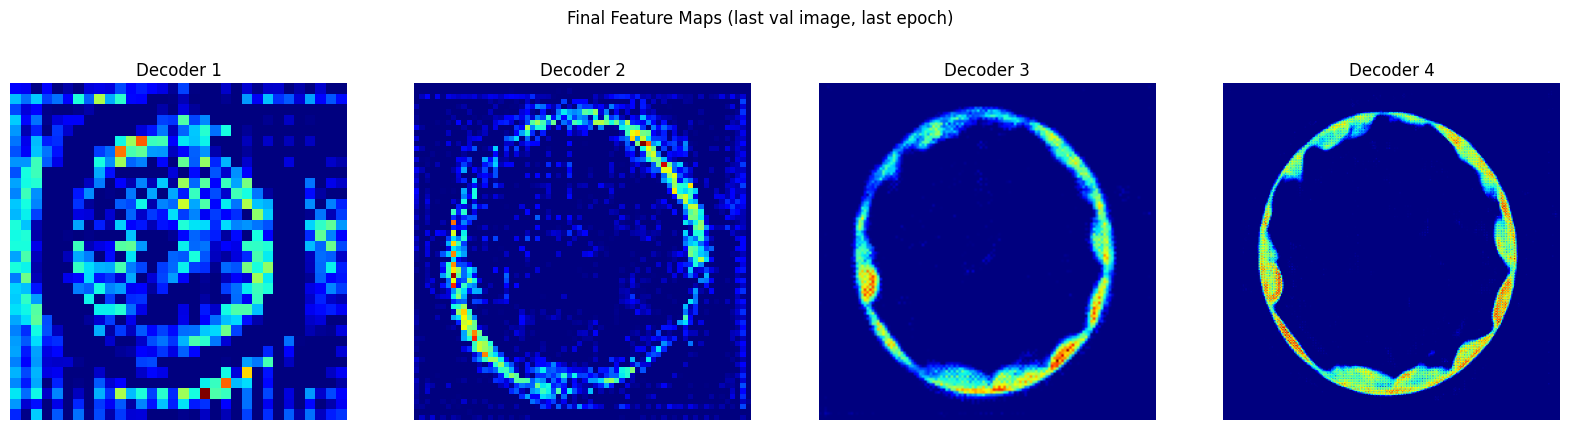

In [ ]:
modelte_ch.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=200,
    callbacks=[feature_map_callback, callbacks],
)

In [ ]:
modelte_ch.evaluate(test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.9658 - dice_coef: 0.8643 - iou: 0.7620 - loss: 0.1380 - precision: 0.8715 - recall: 0.8531


[0.13507667183876038,
 0.868319571018219,
 0.7682874202728271,
 0.9669238328933716,
 0.8557148575782776,
 0.8742451667785645]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf  # Ensure tf is imported

# Get a test sample (image, mask) from the validation dataset
sample = next(iter(valid_dataset))
sample_img = sample[0][0]  # (H, W, C)
sample_mask = sample[1][0]  # (H, W, 1) or (H, W)

# Expand dims for prediction
sample_img_exp = tf.expand_dims(sample_img, axis=0)  # (1, H, W, C)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


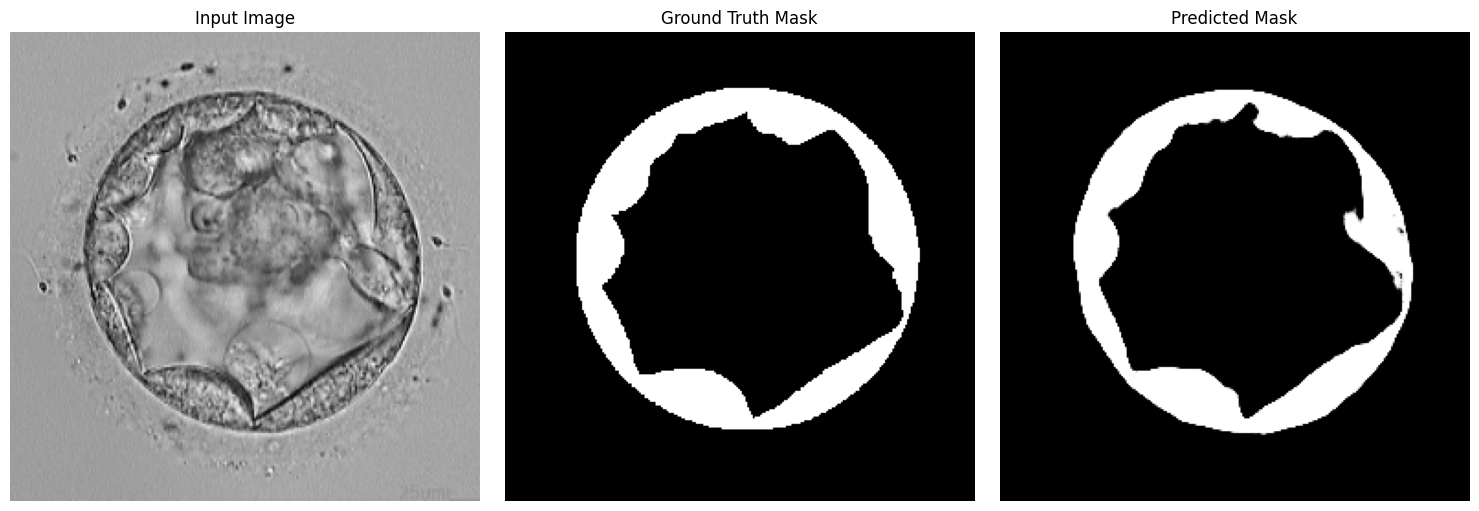

In [ ]:


pred_dict = modelte_ch.predict(sample_img_exp)
output = pred_dict[0]  # (H, W, 1)

# Plotting
plt.figure(figsize=(15, 5))

# Input image
plt.subplot(1, 3, 1)
plt.imshow(sample_img)
plt.title("Input Image")
plt.axis('off')

# Ground truth mask
plt.subplot(1, 3, 2)
plt.imshow(sample_mask[..., 0] if sample_mask.ndim == 3 else sample_mask, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

# Predicted mask
plt.subplot(1, 3, 3)
plt.imshow(output[..., 0], cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
def plot_feature_map(feature, title):
    plt.imshow(np.mean(feature, axis=-1), cmap='viridis')  # Mean across channels
    plt.title(title)
    plt.colorbar()
    plt.axis('off')

In [ ]:

import tensorflow as tf
from tensorflow.keras import layers

def dual_pathway_spatial_attention(x_l, x_h, out_channels,name_prefix="attention"):
    """
    Dual-pathway AG block: spatial attention for decoder stage s.

    Args:
        x_h: high-level feature map (upsampled from decoder)
        x_l: low-level feature map (from encoder)
        out_channels: number of output channels after ΦC conv (e.g., 64, 32, 16)

    Returns:
        Calibrated feature map after dual-pathway attention.
    """
    def single_path_attention(x_l, x_h):
    # Combine high-level and low-level features
      theta_x_l = layers.Conv2D(out_channels, (1, 1), padding='same')(x_l)
      phi_x_h = layers.Conv2D(out_channels, (1, 1), padding='same')(x_h)
      add = layers.Add()([theta_x_l, phi_x_h])
      act = layers.Activation('relu')(add)

    # Spatial Attention using both average and max pooling
      avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(act)
      max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(act)
      concat_pool = layers.Concatenate(axis=-1)([avg_pool, max_pool])  # Shape: (H, W, 2)

      attention = layers.Conv2D(1, (7, 7), padding='same', activation='sigmoid')(concat_pool)
      out = layers.Multiply()([x_l, attention])  # x_l · α

      return out


    # First AG pathway
    ag1 = single_path_attention(x_l, x_h)

    # Second AG pathway (can be made slightly different if needed)
    ag2 = single_path_attention(x_l, x_h)

    # Concatenate both pathways (along channel axis)
    concat = layers.Concatenate(axis=-1)([ag1, ag2])

    # Apply ΦC (1x1 conv + BN + ReLU)
    conv = layers.Conv2D(out_channels, (1, 1), padding='same' , use_bias=False)(concat)
    bn = layers.BatchNormalization()(conv)
    out = layers.Activation('relu',name=f"{name_prefix}_outskip")(bn)

    return out


In [ ]:
def decoder_blocksp(x, skip, filters,name_prefix="decoder"):
    x = conv_block(x, filters*2)
    x = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(x)
    xatt = dual_pathway_spatial_attention(skip, x, filters,name_prefix=f"{name_prefix}_dualattention")
    out = layers.Concatenate(axis=-1)([x, xatt])
    out = conv_block(out, filters)
    return out,xatt


In [ ]:
def build_unetsp(input_shape):
    inputs = tf.keras.Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4 = conv_block(p3, 512, dropout=True)
    p4 = layers.MaxPooling2D((2, 2))(s4)

    # Apply dropout in bottleneck
    b1 = conv_block(p4, 1024, dropout=True)

    d1 = decoder_block(b1, s4, 512)
    d2,f2 = decoder_blocksp(d1, s3, 256,name_prefix="decoder2")
    d3,f3 = decoder_blocksp(d2, s2, 128,name_prefix="decoder3")
    d4,f4 = decoder_blocksp(d3, s1, 64,name_prefix="decoder4")

    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid",name="segmentation_output")(d4)

    return Model(inputs=inputs, outputs=outputs)

In [ ]:
# Now build and compile model like you did
input_shape = ((SIZE, SIZE, 3))
modelte_sp = build_unetsp(input_shape)
modelte_sp.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, weight_decay=1e-8),
    loss=dice_loss,
    metrics=metrics
)

In [ ]:
layer_names = [
    "decoder2_dualattention_outskip",
    "decoder3_dualattention_outskip",
    "decoder4_dualattention_outskip"
]
# Create a new model that outputs the attention layers
feature_extractor = tf.keras.Model(inputs=modelzp_sp.input,
                                   outputs=[modelzp_sp.get_layer(name).output for name in layer_names])

In [ ]:
feature_map_callback = FinalFeatureMapCallback(feature_extractor, val_data=valid_dataset)


Epoch 1/2
63/63 ━━━━━━━━━━━━━━━━━━━━ 594s 7s/step - accuracy: 0.6586 - dice_coef: 0.3748 - iou: 0.3067 - loss: 0.6252 - precision: 0.3012 - recall: 0.8020 - val_accuracy: 0.8350 - val_dice_coef: 0.1888 - val_iou: 0.0028 - val_loss: 0.8081 - val_precision: 0.3334 - val_recall: 0.0038 - learning_rate: 1.0000e-04
Epoch 2/2
63/63 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.9177 - dice_coef: 0.6419 - iou: 0.6429 - loss: 0.3581 - precision: 0.6695 - recall: 0.9413 - val_accuracy: 0.8271 - val_dice_coef: 0.1493 - val_iou: 0.0246 - val_loss: 0.8484 - val_precision: 0.2635 - val_recall: 0.0287 - learning_rate: 1.0000e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


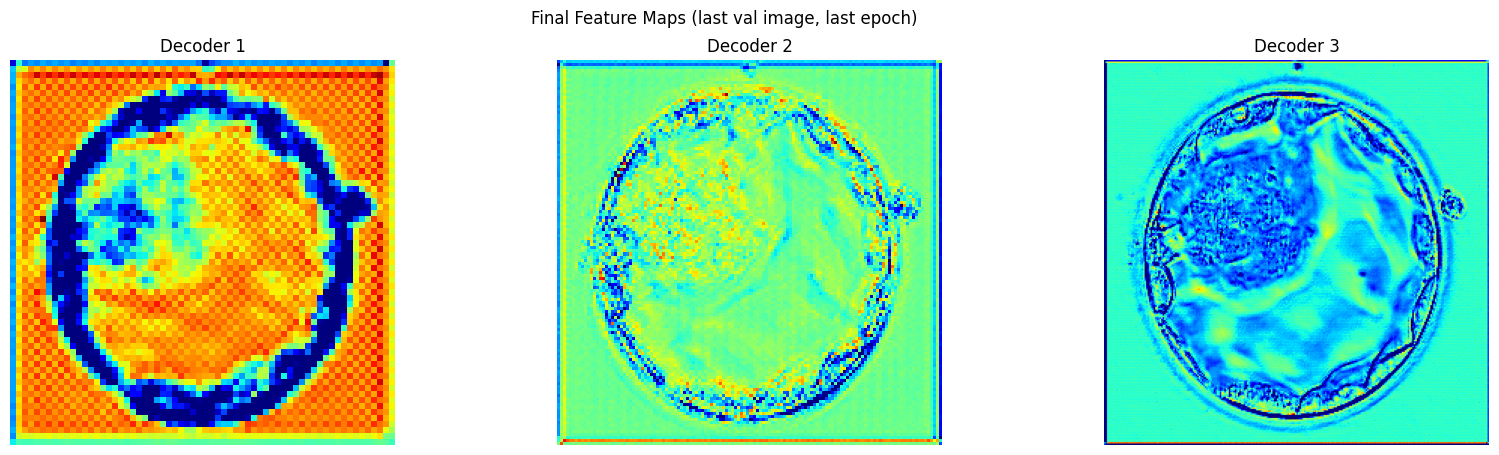

In [ ]:

modelte_sp.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=2,
    callbacks=[feature_map_callback, callbacks],
)

In [ ]:
modelte_sp.evaluate(test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.8295 - dice_coef: 0.1484 - iou: 0.0228 - loss: 0.8529 - precision: 0.2608 - recall: 0.0204


[0.8511782288551331,
 0.15088041126728058,
 0.028262585401535034,
 0.8318517804145813,
 0.02454364113509655,
 0.2661247253417969]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


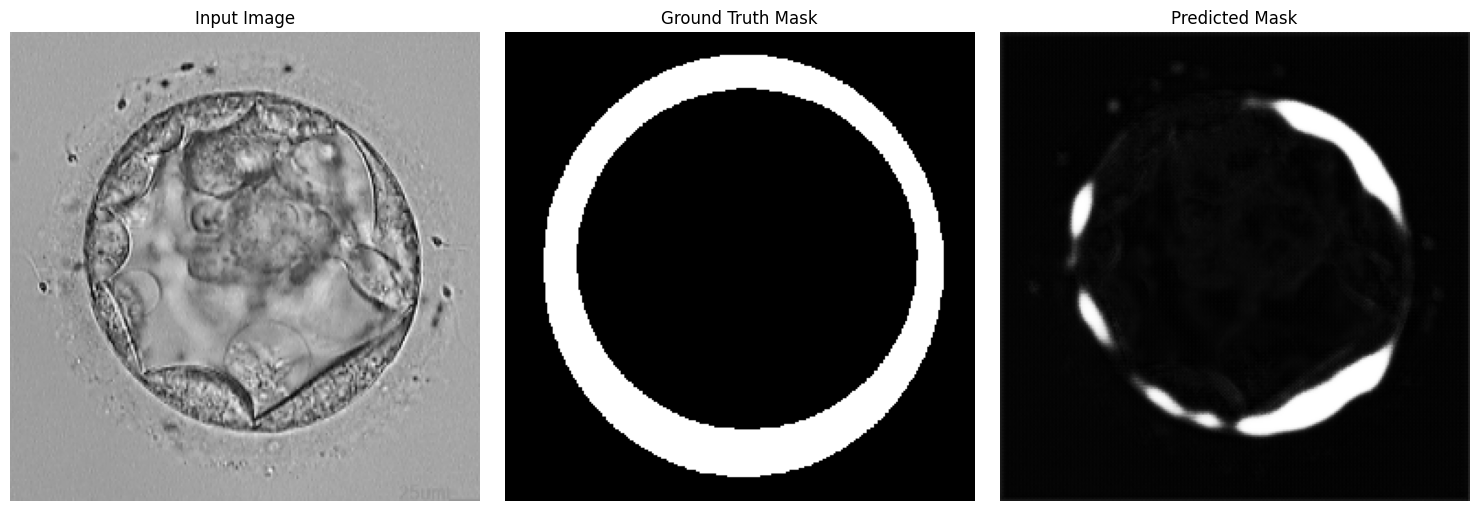

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf  # Ensure tf is imported

pred_dict = modelte_sp.predict(sample_img_exp)
output = pred_dict[0]  # (H, W, 1)

# Plotting
plt.figure(figsize=(15, 5))

# Input image
plt.subplot(1, 3, 1)
plt.imshow(sample_img)
plt.title("Input Image")
plt.axis('off')

# Ground truth mask
plt.subplot(1, 3, 2)
plt.imshow(sample_mask[..., 0] if sample_mask.ndim == 3 else sample_mask, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

# Predicted mask
plt.subplot(1, 3, 3)
plt.imshow(output[..., 0], cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras import layers, backend as K
import tensorflow as tf

def SA1_non_local_attention(x, inter_channels=64,name_prefix="attention"):
    input_channels = x.shape[-1]
    H, W = x.shape[1], x.shape[2]  # Capture symbolic H and W

    # Step 1: Reduce channels
    x_0   = layers.Conv2D(inter_channels, (1, 1), padding='same')(x)
    x_00  = layers.Conv2D(inter_channels, (1, 1), padding='same')(x)
    x_000 = layers.Conv2D(inter_channels, (1, 1), padding='same')(x)

    # Step 2: Flatten (B, H, W, C) → (B, H*W, C)
    def reshape_for_attention(y):
        return tf.reshape(y, (tf.shape(y)[0], -1, inter_channels))  # (B, HW, C)

    x_theta = layers.Lambda(reshape_for_attention, output_shape=(None, None, inter_channels))(x_0)
    x_phi   = layers.Lambda(reshape_for_attention, output_shape=(None, None, inter_channels))(x_00)
    x_g     = layers.Lambda(reshape_for_attention, output_shape=(None, None, inter_channels))(x_000)

    # Step 3: Attention weights
    attention_scores = layers.Lambda(
        lambda inputs: tf.matmul(inputs[0], inputs[1], transpose_b=True),
        output_shape=(None, None, None)
    )([x_theta, x_phi])

    attention = layers.Activation('softmax')(attention_scores)

    # Step 4: Apply attention: α · g
    x_att = layers.Lambda(
        lambda inputs: tf.matmul(inputs[0], inputs[1]),
        output_shape=(None, None, inter_channels)
    )([attention, x_g])

    # Step 5: Reshape back to (B, H, W, C)
    def reshape_back(y):
        return tf.reshape(y, (-1, H, W, inter_channels))

    x_att_reshaped = layers.Lambda(reshape_back, output_shape=(H, W, inter_channels))(x_att)

    # Step 6: Project back to input channels
    x_out = layers.Conv2D(input_channels, (1, 1), padding='same', use_bias=False)(x_att_reshaped)
    x_out = layers.BatchNormalization()(x_out)
    final=layers.Add(name=f"{name_prefix}_final_add")([x_out, x])
    return final,x_out


In [ ]:
def decoder_blocknlb(x, skip, filters,name_prefix="decoder"):
    x = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(x)
    x = layers.Concatenate()([x, skip])
    x,f = SA1_non_local_attention(x,name_prefix=f"{name_prefix}_nlbattention")
    x = conv_block(x, filters)
    return x,f


In [ ]:
def build_unetnlb(input_shape):
    inputs = tf.keras.Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4 = conv_block(p3, 512, dropout=True)
    p4 = layers.MaxPooling2D((2, 2))(s4)

    # Apply dropout in bottleneck
    b1 = conv_block(p4, 1024, dropout=True)

    d1,f1 = decoder_blocknlb(b1, s4, 512,name_prefix="decoder1")
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid",name ="segmentation_output")(d4)

    return Model(inputs=inputs, outputs=outputs)

In [ ]:
input_shape = ((SIZE, SIZE, 3))
modelte_nlb = build_unetnlb(input_shape)
modelte_nlb.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, weight_decay=1e-8),
    loss=dice_loss,
    metrics=metrics
)

In [ ]:
layer_names = [
    "decoder1_nlbattention_final_add",

]
# Create a new model that outputs the attention layers
feature_extractor = tf.keras.Model(inputs=modelte_nlb.input,
                                   outputs=[modelte_nlb.get_layer(name).output for name in layer_names])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

class FinalFeatureMapCallback(tf.keras.callbacks.Callback):
    def __init__(self, feature_extractor, val_data):
        super(FinalFeatureMapCallback, self).__init__()
        self.feature_extractor = feature_extractor
        self.val_data = val_data

    def on_train_end(self, logs=None):
        # Get the last image from the last batch of val_data
        last_image = None
        for batch in self.val_data:
            last_image = batch[0]  # (inputs, labels)

        if last_image is None:
            print("Validation data is empty.")
            return

        image = last_image[-1:]  # shape (1, H, W, C)

        # Get feature maps
        feature_maps = self.feature_extractor.predict(image)

        # Plot the first channel of each decoder output
        fig, axes = plt.subplots(1, 2, figsize=(20, 5))
        for i, fmap in enumerate(feature_maps):
            fmap = np.squeeze(fmap)  # (H, W, C)
            axes[i].imshow(fmap[:, :, 0], cmap='jet')  # first channel
            axes[i].set_title(f'Decoder {i + 1}')
            axes[i].axis('off')

        plt.suptitle('Final Feature Maps (last val image, last epoch)')
        plt.show()


In [ ]:
feature_map_callback = FinalFeatureMapCallback(feature_extractor, val_data=valid_dataset)


Epoch 1/2
63/63 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.6567 - dice_coef: 0.3698 - iou: 0.2869 - loss: 0.6303 - precision: 0.2861 - recall: 0.7156 - val_accuracy: 0.7995 - val_dice_coef: 0.2314 - val_iou: 0.0791 - val_loss: 0.7621 - val_precision: 0.2678 - val_recall: 0.1266 - learning_rate: 1.0000e-04
Epoch 2/2
63/63 ━━━━━━━━━━━━━━━━━━━━ 108s 858ms/step - accuracy: 0.9191 - dice_coef: 0.6768 - iou: 0.6367 - loss: 0.3232 - precision: 0.6856 - recall: 0.8997 - val_accuracy: 0.8225 - val_dice_coef: 0.1965 - val_iou: 0.0754 - val_loss: 0.7949 - val_precision: 0.3590 - val_recall: 0.1011 - learning_rate: 1.0000e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


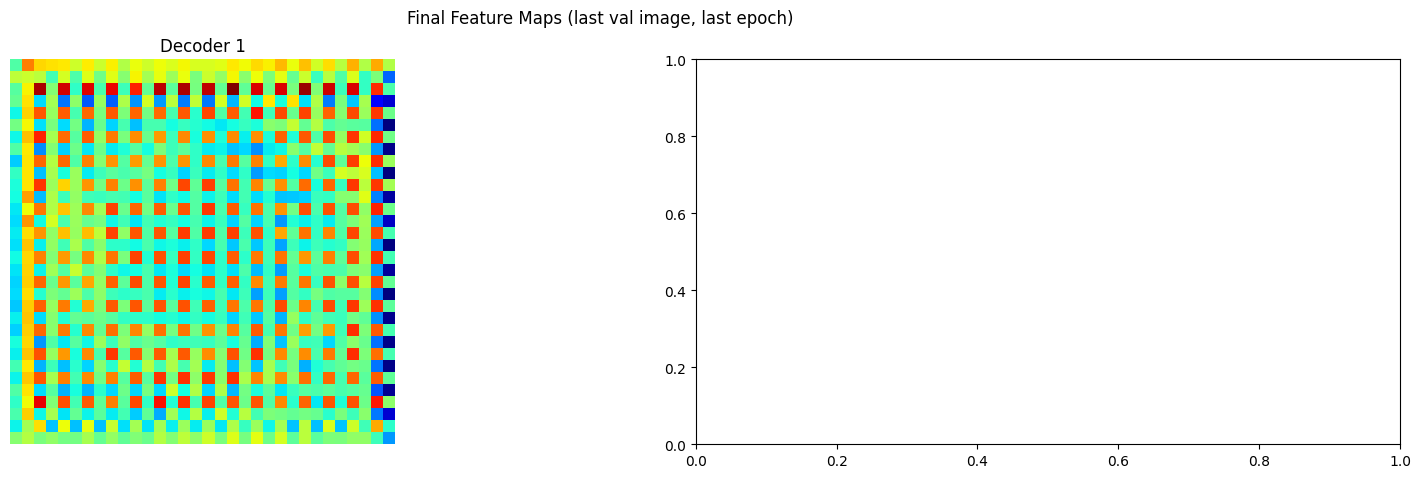

In [ ]:


# Train with dataset
modelte_nlb.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=2,
    callbacks=[callbacks, feature_map_callback],
)

In [ ]:
modelte_nlb.evaluate(test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.8323 - dice_coef: 0.2119 - iou: 0.0906 - loss: 0.7877 - precision: 0.4623 - recall: 0.1000


[0.7882606387138367,
 0.2110947072505951,
 0.09314391016960144,
 0.8330132961273193,
 0.10367245972156525,
 0.42614784836769104]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


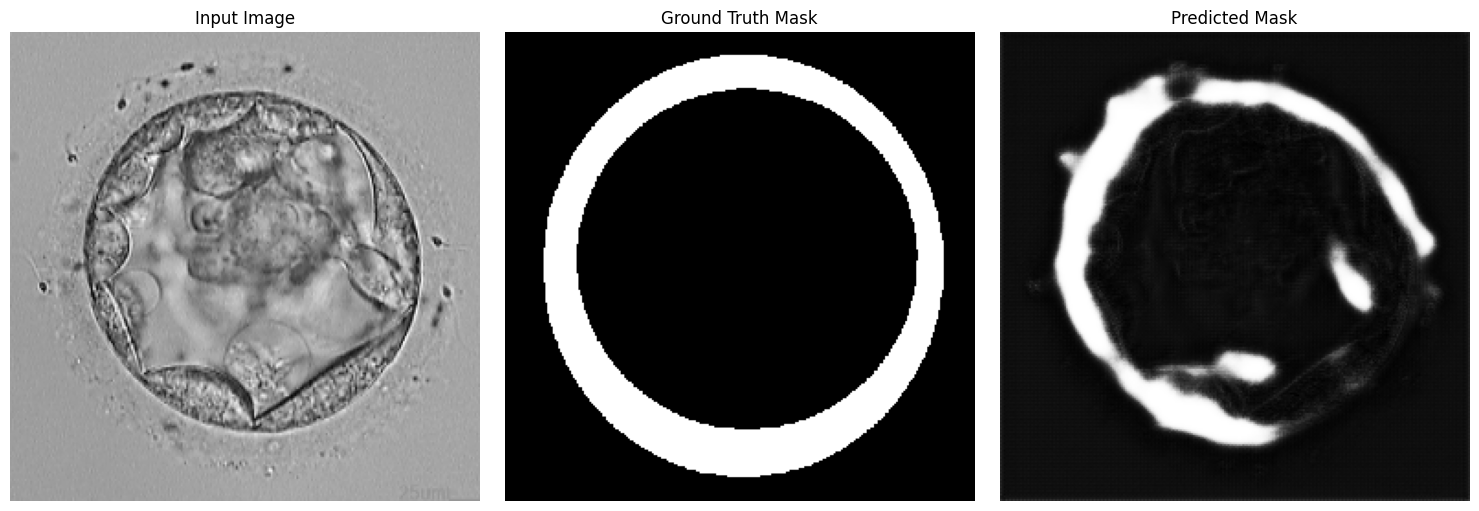

In [ ]:

pred_dict = modelte_nlb.predict(sample_img_exp)
output = pred_dict[0]  # (H, W, 1)

# Plotting
plt.figure(figsize=(15, 5))

# Input image
plt.subplot(1, 3, 1)
plt.imshow(sample_img)
plt.title("Input Image")
plt.axis('off')

# Ground truth mask
plt.subplot(1, 3, 2)
plt.imshow(sample_mask[..., 0] if sample_mask.ndim == 3 else sample_mask, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

# Predicted mask
plt.subplot(1, 3, 3)
plt.imshow(output[..., 0], cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
def build_unetspt(input_shape):
    inputs = tf.keras.Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4 = conv_block(p3, 512, dropout=True)
    p4 = layers.MaxPooling2D((2, 2))(s4)

    b1 = conv_block(p4, 1024, dropout=True)

    d1,SA1 = decoder_blocknlb(b1, s4, 512, name_prefix="decoder1")
    d2,SA2= decoder_blocksp(d1, s3, 256,name_prefix="decoder2")
    d3,SA3 = decoder_blocksp(d2, s2, 128,name_prefix="decoder3")
    d4,SA4 = decoder_blocksp(d3, s1, 64,name_prefix="decoder4")
    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid", name="segmentation_output")(d4)

    return Model(inputs=inputs, outputs=outputs)

In [ ]:
input_shape = ((SIZE, SIZE, 3))
modelte_spt = build_unetspt(input_shape)
modelte_spt.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, weight_decay=1e-8),
    loss=dice_loss,
    metrics=metrics
)

In [ ]:
for layer in modelte_spt.layers:
    print(layer.name)


input_layer_1
conv2d_49
batch_normalization_28
activation_31
conv2d_50
batch_normalization_29
activation_32
max_pooling2d_4
conv2d_51
batch_normalization_30
activation_33
conv2d_52
batch_normalization_31
activation_34
max_pooling2d_5
conv2d_53
batch_normalization_32
activation_35
conv2d_54
batch_normalization_33
activation_36
max_pooling2d_6
conv2d_55
batch_normalization_34
activation_37
conv2d_56
batch_normalization_35
activation_38
dropout_2
max_pooling2d_7
conv2d_57
batch_normalization_36
activation_39
conv2d_58
batch_normalization_37
activation_40
dropout_3
conv2d_transpose_4
concatenate_13
conv2d_59
conv2d_60
lambda_18
lambda_19
lambda_21
conv2d_61
activation_41
lambda_20
lambda_22
lambda_23
conv2d_62
batch_normalization_38
decoder1_nlbattention_final_add
conv2d_63
batch_normalization_39
activation_42
conv2d_64
batch_normalization_40
activation_43
conv2d_65
batch_normalization_41
activation_44
conv2d_66
batch_normalization_42
activation_45
conv2d_transpose_5
conv2d_67
conv2d_68
co

In [ ]:
layer_names = [
    "decoder1_nlbattention_final_add",
    "decoder2_dualattention_outskip",
    "decoder3_dualattention_outskip",
    "decoder4_dualattention_outskip",
]
# Create a new model that outputs the attention layers
feature_extractor = tf.keras.Model(inputs=modelte_spt.input,
                                   outputs=[modelte_spt.get_layer(name).output for name in layer_names])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

class FinalFeatureMapCallback(tf.keras.callbacks.Callback):
    def __init__(self, feature_extractor, val_data):
        super(FinalFeatureMapCallback, self).__init__()
        self.feature_extractor = feature_extractor
        self.val_data = val_data

    def on_train_end(self, logs=None):
        # Get the last image from the last batch of val_data
        last_image = None
        for batch in self.val_data:
            last_image = batch[0]  # (inputs, labels)

        if last_image is None:
            print("Validation data is empty.")
            return

        image = last_image[-1:]  # shape (1, H, W, C)

        # Get feature maps
        feature_maps = self.feature_extractor.predict(image)

        # Plot the first channel of each decoder output
        fig, axes = plt.subplots(1, len(feature_maps), figsize=(20, 5))
        for i, fmap in enumerate(feature_maps):
            fmap = np.squeeze(fmap)  # (H, W, C)
            axes[i].imshow(fmap[:, :, 0], cmap='jet')  # first channel
            axes[i].set_title(f'Decoder {i + 1}')
            axes[i].axis('off')

        plt.suptitle('Final Feature Maps (last val image, last epoch)')
        plt.show()


In [ ]:
feature_map_callback = FinalFeatureMapCallback(feature_extractor, val_data=valid_dataset)


Epoch 1/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 517s 6s/step - accuracy: 0.8210 - dice_coef: 0.3846 - iou: 0.3277 - loss: 0.6155 - precision: 0.3647 - recall: 0.7182 - val_accuracy: 0.8708 - val_dice_coef: 0.1824 - val_iou: 0.0452 - val_loss: 0.8150 - val_precision: 0.3174 - val_recall: 0.0640 - learning_rate: 1.0000e-04
Epoch 2/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.9283 - dice_coef: 0.6741 - iou: 0.5924 - loss: 0.3259 - precision: 0.6484 - recall: 0.8710 - val_accuracy: 0.8796 - val_dice_coef: 0.0945 - val_iou: 4.2647e-05 - val_loss: 0.9054 - val_precision: 1.0000 - val_recall: 5.5779e-05 - learning_rate: 1.0000e-04
Epoch 3/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9461 - dice_coef: 0.7354 - iou: 0.6568 - loss: 0.2646 - precision: 0.7304 - recall: 0.8662 - val_accuracy: 0.8879 - val_dice_coef: 0.1959 - val_iou: 0.1035 - val_loss: 0.7777 - val_precision: 0.6677 - val_recall: 0.1368 - learning_rate: 1.0000e-04
Epoch 4/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/ste

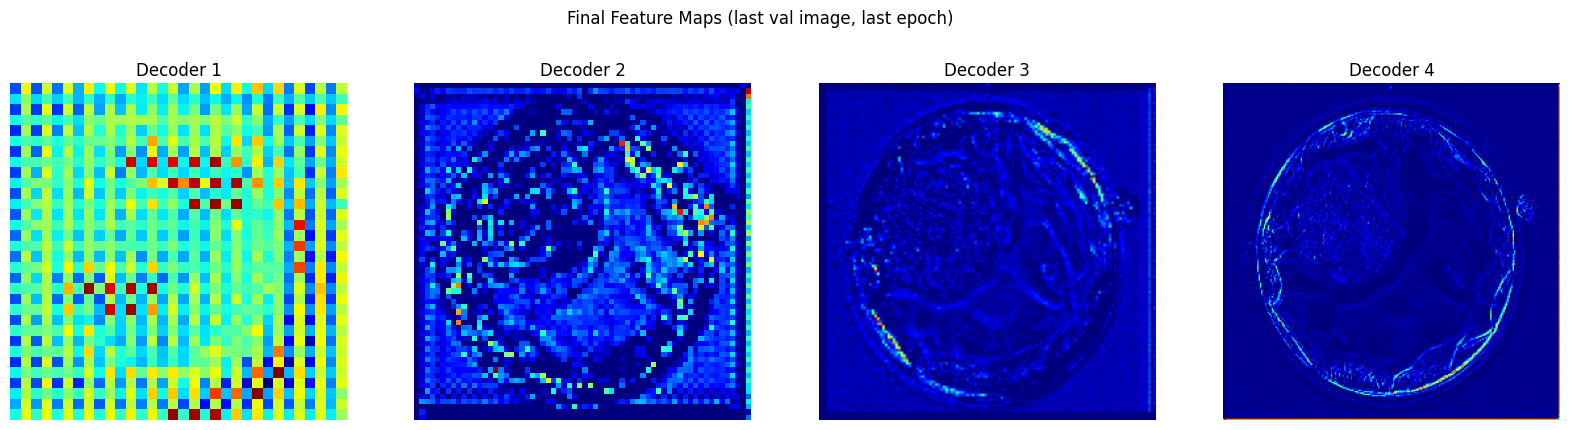

In [ ]:


# Train with dataset
modelte_spt.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=200,
    callbacks=[callbacks,feature_map_callback]
)

In [ ]:
modelte_spt.evaluate(test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.9631 - dice_coef: 0.8460 - iou: 0.7370 - loss: 0.1558 - precision: 0.8857 - recall: 0.8103


[0.15345221757888794,
 0.8492672443389893,
 0.7420687675476074,
 0.9641186594963074,
 0.8127016425132751,
 0.8877583146095276]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


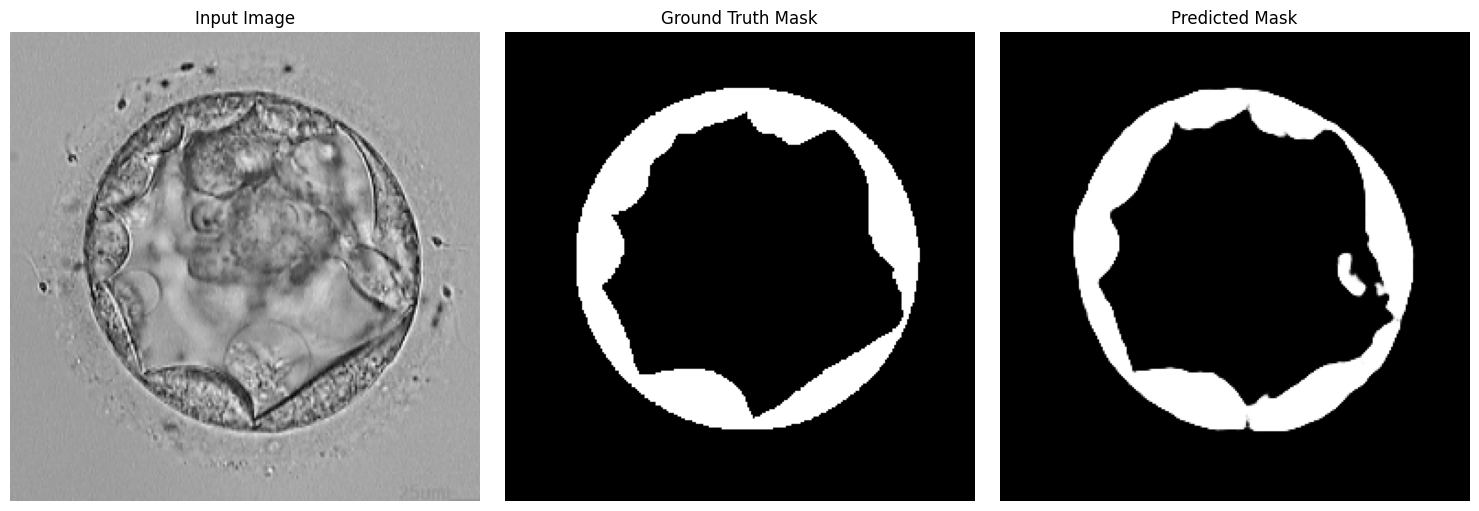

In [ ]:

pred_dict = modelte_spt.predict(sample_img_exp)
output = pred_dict[0]  # (H, W, 1)

# Plotting
plt.figure(figsize=(15, 5))

# Input image
plt.subplot(1, 3, 1)
plt.imshow(sample_img)
plt.title("Input Image")
plt.axis('off')

# Ground truth mask
plt.subplot(1, 3, 2)
plt.imshow(sample_mask[..., 0] if sample_mask.ndim == 3 else sample_mask, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

# Predicted mask
plt.subplot(1, 3, 3)
plt.imshow(output[..., 0], cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
def decoder_blockspc(x,skip, filters,name_prefix="decoder"):
    x = conv_block(x, filters*2)
    x = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(x)
    skipatt=dual_pathway_spatial_attention(skip,x,filters,name_prefix=f"{name_prefix}_dualattention")
    x = layers.Concatenate(axis=-1)([x, skipatt])
    x = conv_block(x, filters)
    x,vec,ch=channel_attention(x,name_prefix=f"{name_prefix}_channelattention")
    return x,vec,ch,skipatt


In [ ]:
def decoder_blocknlbc(x, skip, filters,name_prefix="decoder"):
    x = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(x)
    x = layers.Concatenate()([x, skip])
    x,f = SA1_non_local_attention(x,name_prefix=f"{name_prefix}_nlbattention")
    x = conv_block(x, filters)
    x,vec,ch=channel_attention(x,name_prefix=f"{name_prefix}_channelattention")
    return x,vec,ch,f


In [ ]:
def build_unetsptc(input_shape):
    inputs = tf.keras.Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4 = conv_block(p3, 512, dropout=True)
    p4 = layers.MaxPooling2D((2, 2))(s4)

    # Apply dropout in bottleneck
    b1 = conv_block(p4, 1024, dropout=True)

    d1,vec,ch1,SA1 = decoder_blocknlbc(b1, s4, 512,name_prefix="decoder1")
    d2,vec,ch2,SA2 = decoder_blockspc(d1, s3, 256,name_prefix="decoder2")
    d3,vec,ch3,SA3 = decoder_blockspc(d2, s2, 128,name_prefix="decoder3")
    d4,vec,ch4,SA4 = decoder_blockspc(d3, s1, 64,name_prefix="decoder4")

    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    return Model(inputs, outputs)

In [ ]:
input_shape = ((SIZE, SIZE, 3))
modelte_sptc = build_unetsptc(input_shape)
modelte_sptc.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, weight_decay=1e-8),
    loss=dice_loss,
    metrics=metrics
)

In [ ]:
layer_names = [
    "decoder1_nlbattention_final_add",
    "decoder1_channelattention_final_add",
    "decoder2_dualattention_outskip",
    "decoder2_channelattention_final_add",
    "decoder3_dualattention_outskip",
    "decoder3_channelattention_final_add",
    "decoder4_dualattention_outskip",
    "decoder4_channelattention_final_add"
]
# Create a new model that outputs the attention layers
feature_extractor = tf.keras.Model(inputs=modelte_sptc.input,
                                   outputs=[modelte_sptc.get_layer(name).output for name in layer_names])



In [ ]:
feature_map_callback = FinalFeatureMapCallback(feature_extractor, val_data=valid_dataset)


Epoch 1/2
63/63 ━━━━━━━━━━━━━━━━━━━━ 936s 13s/step - accuracy: 0.7377 - dice_coef: 0.4015 - iou: 0.2907 - loss: 0.5987 - precision: 0.3268 - recall: 0.6246 - val_accuracy: 0.8023 - val_dice_coef: 0.2842 - val_iou: 0.1734 - val_loss: 0.7088 - val_precision: 0.3616 - val_recall: 0.2647 - learning_rate: 1.0000e-04
Epoch 2/2
63/63 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.9305 - dice_coef: 0.7704 - iou: 0.6580 - loss: 0.2296 - precision: 0.7429 - recall: 0.8518 - val_accuracy: 0.8344 - val_dice_coef: 0.0669 - val_iou: 0.0062 - val_loss: 0.9318 - val_precision: 0.3187 - val_recall: 0.0066 - learning_rate: 1.0000e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


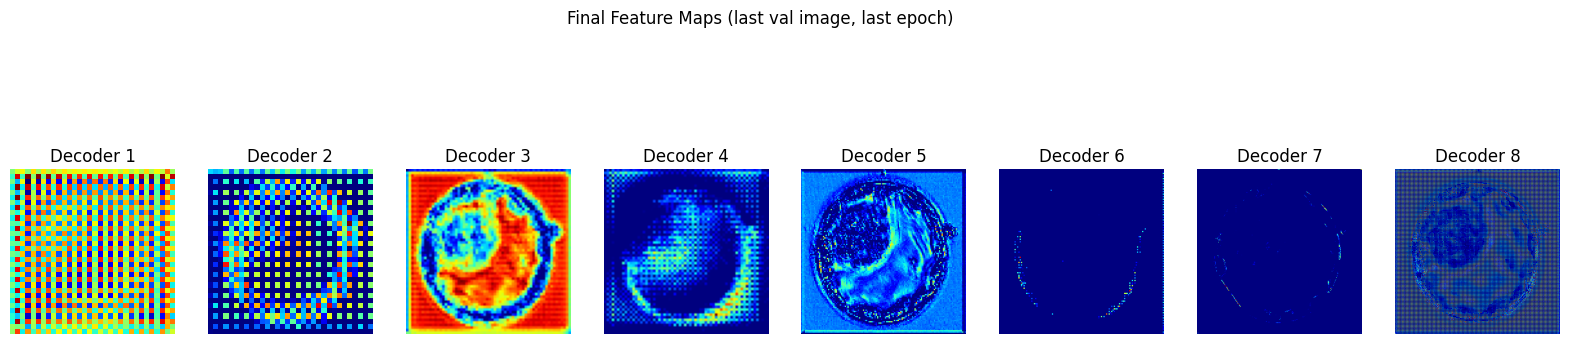

In [ ]:


# Train with dataset
modelte_sptc.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=2,
    callbacks=[callbacks,feature_map_callback]
)

In [ ]:
modelte_sptc.evaluate(test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 27s 12s/step - accuracy: 0.8341 - dice_coef: 0.0776 - iou: 0.0138 - loss: 0.9241 - precision: 0.3728 - recall: 0.0125


[0.9219367504119873,
 0.08058851957321167,
 0.016138453036546707,
 0.8370507955551147,
 0.014062801375985146,
 0.3604775369167328]

In [16]:
def scale_attention_module(features,name_prefix="attention"):
    """
    Paper-faithful Scale Attention Module (CA-Net) with symbolic shape fix.
    Args:
        features: list of decoder feature maps from 4 different scales (d1 to d4)
    Returns:
        Final enhanced feature map (B, H, W, 4)
    """
    H, W = features[3].shape[1], features[3].shape[2]  # symbolic-safe shape

    # 1. Resize all feature maps to same shape
    resized = [layers.Resizing(H, W, interpolation='bilinear')(f) for f in features]

    # 2. Compress to 1 channel per scale
    compressed = [layers.Conv2D(1, (1, 1), padding='same')(f) for f in resized]

    # 3. Concatenate → F̂ (B, H, W, 4)
    F_hat = layers.Concatenate(axis=-1)(compressed)
    shared_dense_one = layers.Dense(8 , activation='relu', kernel_initializer='he_normal')
    shared_dense_two = layers.Dense(4, kernel_initializer='he_normal')
    # 4. Scale-wise attention γ
    gap = layers.GlobalAveragePooling2D()(F_hat)
    gmp = layers.GlobalMaxPooling2D()(F_hat)
    gap = layers.Reshape((1, 1, 4))(gap)
    gmp = layers.Reshape((1, 1, 4))(gmp)
    gap = shared_dense_two(shared_dense_one(gap))
    gmp = shared_dense_two(shared_dense_one(gmp))
    gamma = layers.Add()([gap, gmp])
    gamma = layers.Activation('sigmoid')(gamma)  # (B, 1, 1, 4)

    F_gamma = layers.Multiply()([F_hat, gamma])  # (B, H, W, 4)

    # 5. Pixel-wise scale attention γ*
    x = layers.Conv2D(4, (3, 3), padding='same', activation='relu')(F_gamma)
    gamma_star = layers.Conv2D(4, (1, 1), padding='same', activation='sigmoid')(x)


    # 6. Final residual + fused output
    out = layers.Add(name=f"{name_prefix}_final")([
        layers.Multiply()([F_gamma, gamma_star]),
        layers.Multiply()([F_hat, gamma]),
        F_hat
    ])
    """
    x = layers.Activation("relu")(out)
    x = layers.Conv2D(4, (3, 3), padding="same", kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu",name=f"{name_prefix}_final")(x)
    """
    return out


In [17]:
def build_unetsc(input_shape):
    inputs = tf.keras.Input(input_shape)

    # ---- Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4 = conv_block(p3, 512, dropout=True)
    p4 = layers.MaxPooling2D((2, 2))(s4)

    # Apply dropout in bottleneck
    b1 = conv_block(p4, 1024, dropout=True)

    # ---- Decoder
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # ---- Scale Attention Module
    la_output = scale_attention_module([d1, d2, d3, d4],name_prefix="scaler")  # returns enhanced feature map

    # ---- Final Output
    output = layers.Conv2D(1, (1, 1), padding='same', activation='sigmoid',name="segmentation_output")(la_output)

    return Model(inputs=inputs, outputs=output)


In [18]:
# Now build and compile model like you did
input_shape = ((SIZE, SIZE, 3))
modelte_sc = build_unetsc(input_shape)
modelte_sc.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, weight_decay=1e-8),
    loss=dice_loss,
    metrics=metrics
)

In [19]:
layer_names = [
"scaler_final"
]
# Create a new model that outputs the attention layers
feature_extractor = tf.keras.Model(inputs=modelte_sc.input,
                                   outputs=[modelte_sc.get_layer(name).output for name in layer_names])



In [20]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

class FinalFeatureMapCallback(tf.keras.callbacks.Callback):
    def __init__(self, feature_extractor, val_data):
        super(FinalFeatureMapCallback, self).__init__()
        self.feature_extractor = feature_extractor
        self.val_data = val_data

    def on_train_end(self, logs=None):
        # Get the last image from the last batch of val_data
        last_image = None
        for batch in self.val_data:
            last_image = batch[0]  # (inputs, labels)

        if last_image is None:
            print("Validation data is empty.")
            return

        image = last_image[-1:]  # shape (1, H, W, C)

        # Get feature maps
        feature_maps = self.feature_extractor.predict(image)

        # Plot the first channel of each decoder output
        fig, axes = plt.subplots(1, 2, figsize=(20, 5))
        for i, fmap in enumerate(feature_maps):
            fmap = np.squeeze(fmap)  # (H, W, C)
            axes[i].imshow(fmap[:, :, 0], cmap='jet')  # first channel
            axes[i].set_title(f'Decoder {i + 1}')
            axes[i].axis('off')

        plt.suptitle('Final Feature Maps (last val image, last epoch)')
        plt.show()


In [21]:
feature_map_callback = FinalFeatureMapCallback(feature_extractor, val_data=valid_dataset)


In [ ]:


# Train with dataset
modelte_sc.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=200,
    callbacks=[callbacks,feature_map_callback]
)

Epoch 1/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.8368 - dice_coef: 0.5321 - iou: 0.3929 - loss: 0.4679 - precision: 0.5403 - recall: 0.8778 - val_accuracy: 0.8796 - val_dice_coef: 0.0614 - val_iou: 1.1204e-20 - val_loss: 0.9378 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.9375 - dice_coef: 0.7526 - iou: 0.6121 - loss: 0.2475 - precision: 0.6958 - recall: 0.8345 - val_accuracy: 0.8799 - val_dice_coef: 0.0312 - val_iou: 0.0023 - val_loss: 0.9666 - val_precision: 0.8592 - val_recall: 0.0031 - learning_rate: 1.0000e-04
Epoch 3/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.9503 - dice_coef: 0.7975 - iou: 0.6706 - loss: 0.2025 - precision: 0.7588 - recall: 0.8500 - val_accuracy: 0.8825 - val_dice_coef: 0.0720 - val_iou: 0.0222 - val_loss: 0.9222 - val_precision: 0.9439 - val_recall: 0.0253 - learning_rate: 1.0000e-04
Epoch 4/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/s

In [ ]:
modelte_sc.evaluate(test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 6s/step - accuracy: 0.7916 - dice_coef: 0.2505 - iou: 0.1087 - loss: 0.7471 - precision: 0.2630 - recall: 0.1486


[0.7501688599586487,
 0.24620524048805237,
 0.11598773300647736,
 0.7926867604255676,
 0.15884831547737122,
 0.2630796730518341]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


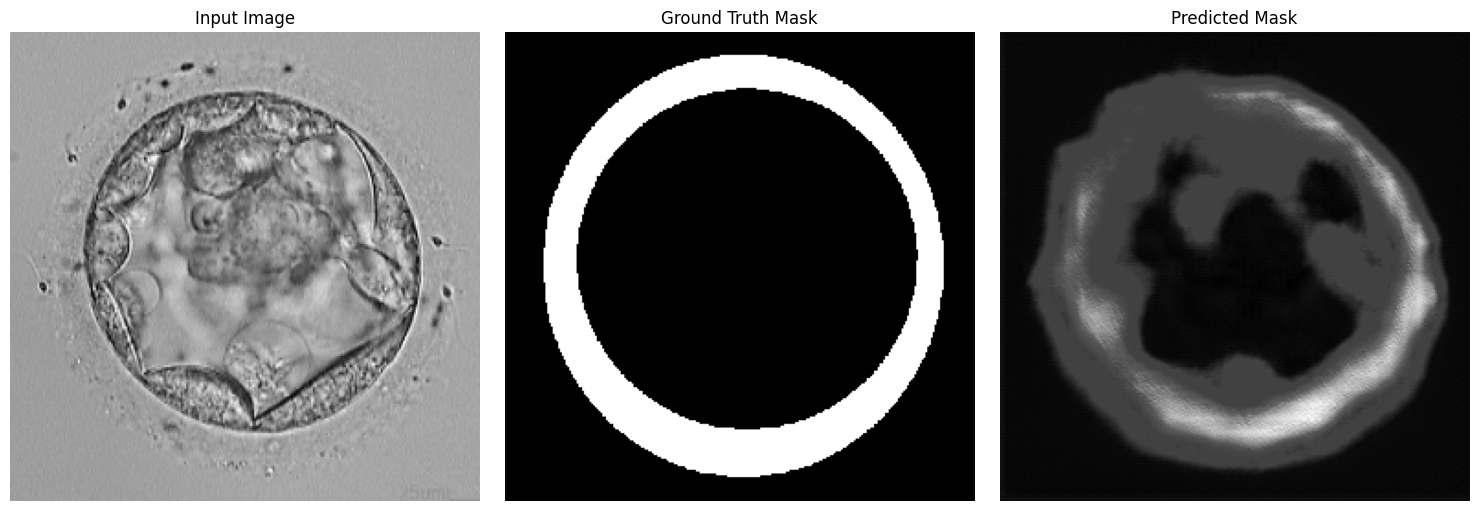

In [ ]:

pred_dict = modelte_sc.predict(sample_img_exp)
output = pred_dict[0]  # (H, W, 1)

# Plotting
plt.figure(figsize=(15, 5))

# Input image
plt.subplot(1, 3, 1)
plt.imshow(sample_img)
plt.title("Input Image")
plt.axis('off')

# Ground truth mask
plt.subplot(1, 3, 2)
plt.imshow(sample_mask[..., 0] if sample_mask.ndim == 3 else sample_mask, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

# Predicted mask
plt.subplot(1, 3, 3)
plt.imshow(output[..., 0], cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.tight_layout()
plt.show()
